In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
tags = ['2024-04-12-15-31-26']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [3]:
# crete a dataframe from runs and summary metrics
# async def add_max_to_summary(run):
#     try:
#         history: pd.DataFrame = run.history()
#         # get the row with the highest Self_Play/Mean_Reward
#         metric = "Self_Play/Mean_Reward"
#         best_row = history.loc[history[metric].idxmax()]
#         run.summary[f'max_{metric}'] = best_row[metric]
#         run.summary[f'max_{metric}_step'] = best_row['_step']
#         run.summary.update()
#     except:
#         pass



# async def get_history(run):
#     return await run.history()

# tasks = []
# for run in runs:
#     if run.state != "finished":
#         continue
#     tasks.append(add_max_to_summary(run))

# await asyncio.gather(*tasks)


data = []
for run in tqdm(runs):
    history: pd.DataFrame = run.history()
    for i, row in history.iterrows():
        # add a row to the data with run.config and the history row merged
        data.append({**run.config, **row})

df = pd.DataFrame(data)

df


100%|██████████| 45/45 [00:15<00:00,  2.96it/s]


,ncols,layers,puct_c,workers,lr_gamma,dir_alpha,eval_temp,env_params,eval_param,hidden_dim,...,Self_Play/Mean_Entropy,Self_Play/Total_Mean_Discounted_Return,Evaluation/Returns,Self_Play/Timesteps,Self_Play/Max_Return,_runtime,Self_Play/Entropies,Evaluation/Entropies,grad_steps,Training/Regularization_loss
0,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.933916,0.002023,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",1.0,93.889906,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...","{'packedBins': {'size': 0.015625000931322575, ...",0.0,266.999542
1,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.948599,0.002460,None,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",1.0,170.948505,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",None,2.0,258.246368
2,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.943895,0.003253,None,"{'packedBins': {'min': 70, 'size': 0.46875, 'c...",1.0,239.313700,"{'bins': [0.8640052676200867, 0.86596614122390...",None,4.0,249.842224
3,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.932570,0.006179,None,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",1.0,306.626174,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",None,6.0,241.809479
4,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.942822,0.006329,None,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",1.0,376.773538,"{'_type': 'histogram', 'values': [1, 0, 0, 0, ...",None,8.0,234.133682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.982269,-0.085423,NaN,"{'_type': 'histogram', 'packedBins': {'min': 1...",1.0,764.202924,"{'bins': [0.9717457294464111, 0.97210532426834...",NaN,32.0,172.715347
941,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.979278,-0.088289,NaN,"{'packedBins': {'min': 8, 'size': 1.4375, 'cou...",1.0,799.493271,"{'_type': 'histogram', 'bins': [0.960083484649...",NaN,34.0,168.711166
942,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.962963,-0.084981,NaN,"{'values': [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0...",1.0,832.570481,"{'_type': 'histogram', 'bins': [0.919039011001...",NaN,36.0,165.135834
943,8,5,1,1,1,2.5,0,"{'id': 'FrozenLake-v1', 'desc': None, 'map_nam...",5,64,...,0.986313,-0.082276,NaN,"{'packedBins': {'count': 64, 'min': 49, 'size'...",0.0,877.529840,"{'values': [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...",NaN,38.0,161.917694


In [4]:
df.columns

Index(['ncols', 'layers', 'puct_c', 'workers', 'lr_gamma', 'dir_alpha',
       'eval_temp', 'env_params', 'eval_param', 'hidden_dim', 'iterations',
       'model_type', 'norm_layer', 'dir_epsilon', 'worst_value',
       'activation_fn', 'learning_rate', 'optimal_value', 'discount_factor',
       'env_description', 'planning_budget', 'training_epochs',
       'use_visit_count', 'n_steps_learning', 'selection_policy',
       'tree_temperature', 'value_loss_weight', 'max_episode_length',
       'policy_loss_weight', 'sample_batch_ratio', 'tree_value_transform',
       'observation_embedding', 'regularization_weight',
       'root_selection_policy', 'episodes_per_iteration',
       'tree_evaluation_policy', 'replay_buffer_multiplier',
       'selection_value_transform', 'Training/Learning_Rate',
       'Training/Value_Simularities', 'Self_Play/Min_Timesteps',
       'Self_Play/Discounted_Return', 'Self_Play/Mean_Timesteps',
       'Self_Play/Returns', 'Evaluation/Mean_Returns',
       'Eva

In [5]:
save_folder = 'outfiles'


def name_fn(name):
    # remove "Self_Play/" prefix if it exists
    if name.startswith("Self_Play/"):
        name = name[len("Self_Play/"):]

    # replace slash with underscore
    name = name.replace("/", "_")

    # change underscore to space
    name = name.replace("_", " ")
    return name

In [6]:
episode_max = df['episodes'].max()
# if episodes is Nan, set it to episode_max
df['episodes'] = df['episodes'].fillna(episode_max)

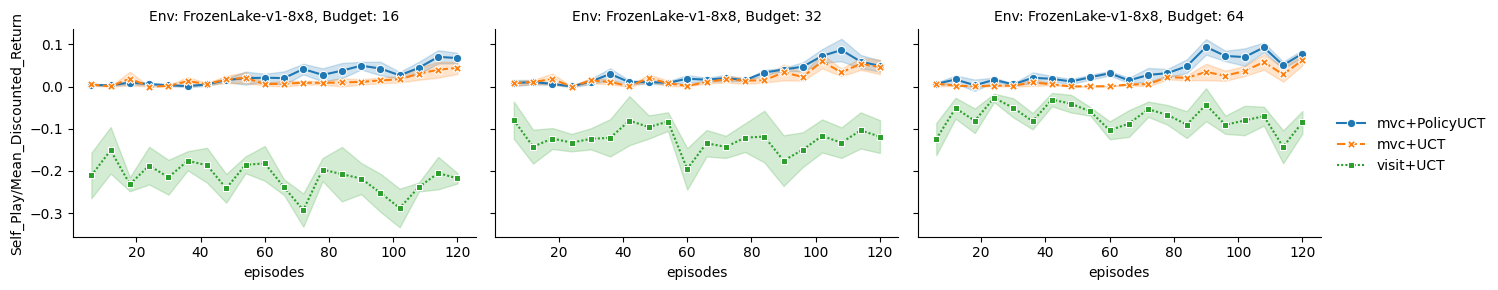

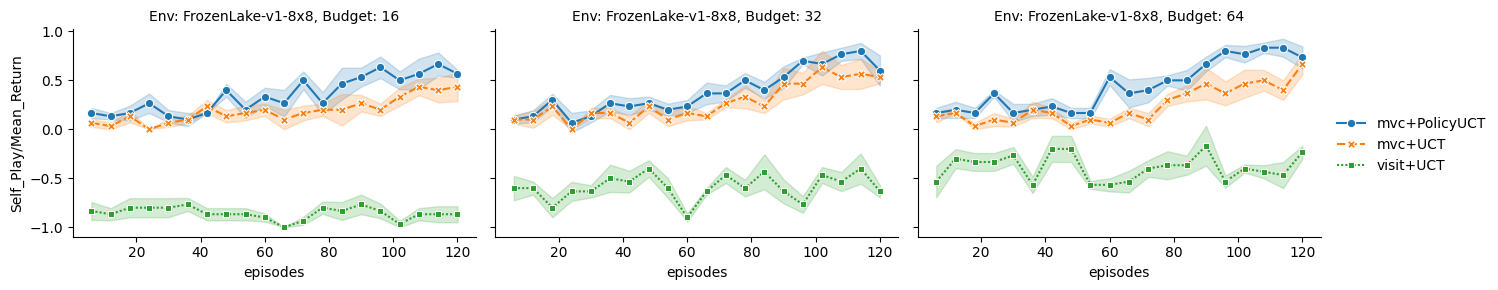

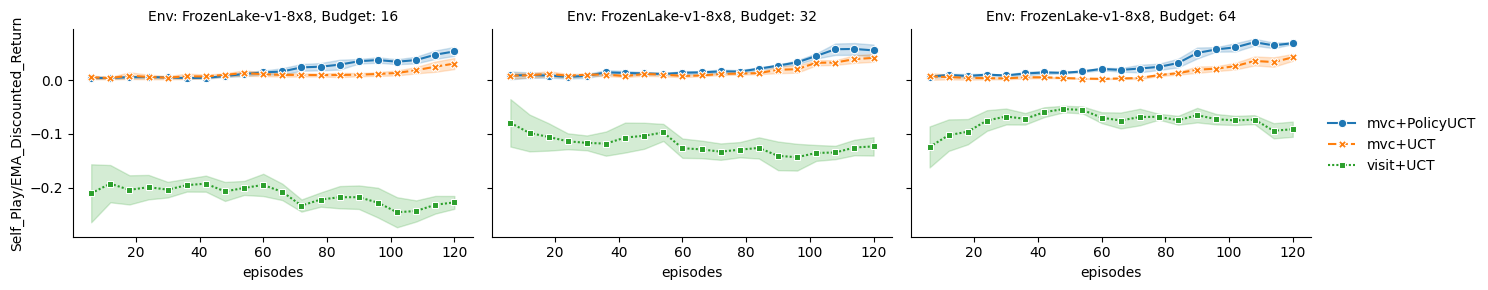

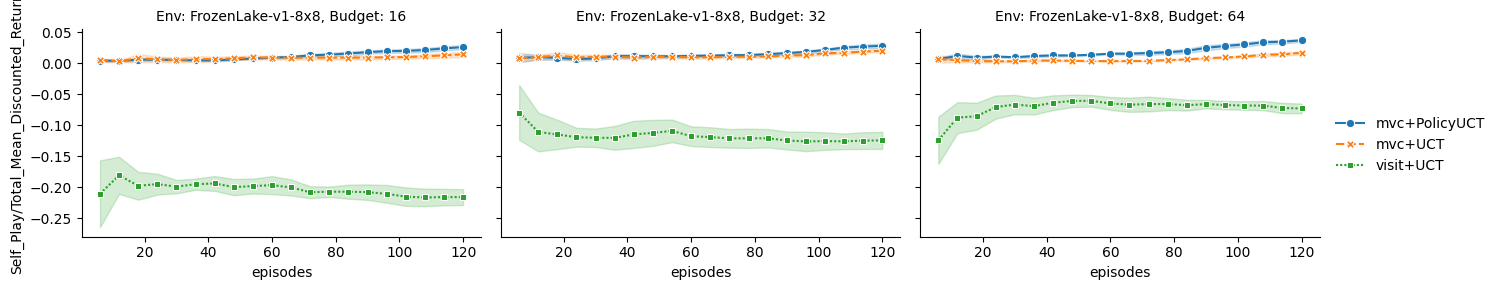

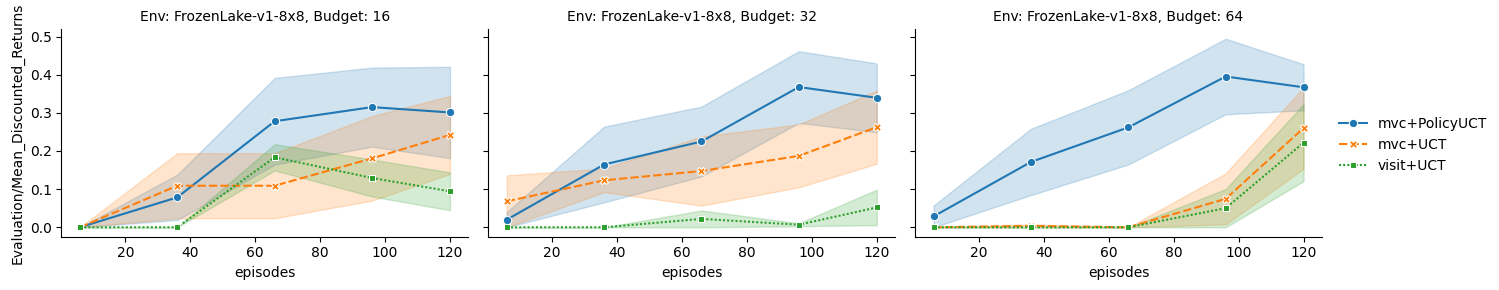

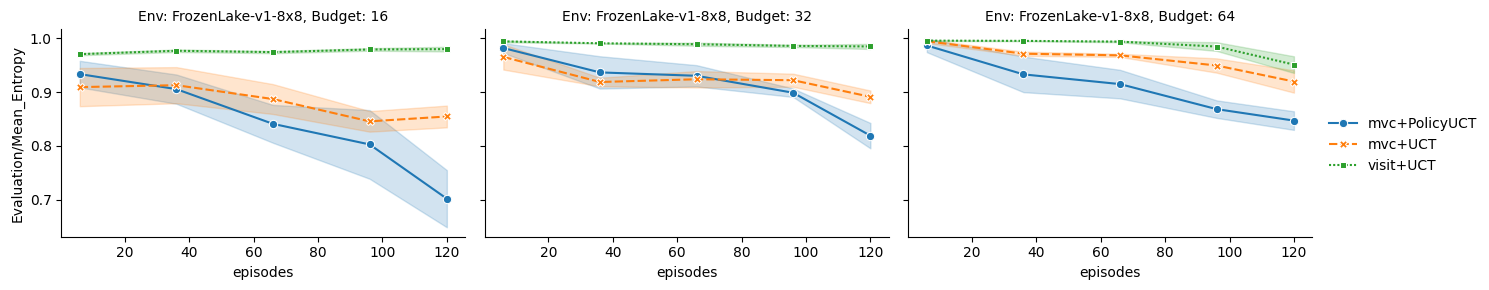

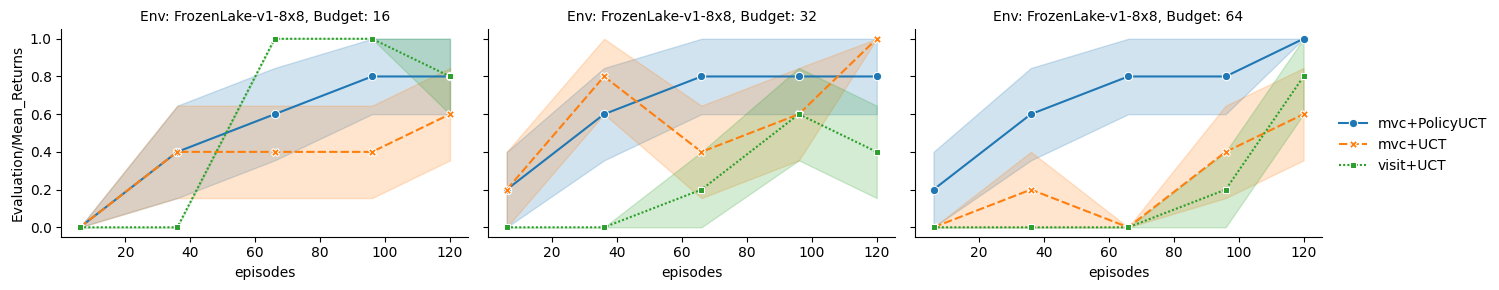

In [7]:





df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Discounted_Return','Self_Play/Mean_Return', 'Self_Play/EMA_Discounted_Return', 'Self_Play/Total_Mean_Discounted_Return',
           "Evaluation/Mean_Discounted_Returns", "Evaluation/Mean_Entropy", "Evaluation/Mean_Returns"]
x_metric = "episodes"

estimator = "mean"

for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(data=df, row="env_description", col="planning_budget", sharex="col", sharey="row", aspect=1.5)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed


    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()
    g.set_titles("Env: {row_name}, Budget: {col_name}")


    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)
    # increase the width of the plot
    # g.fig.set_figwidth(10)
    # plt.suptitle(metric)
    # plt.tight_layout()
    plt.show()

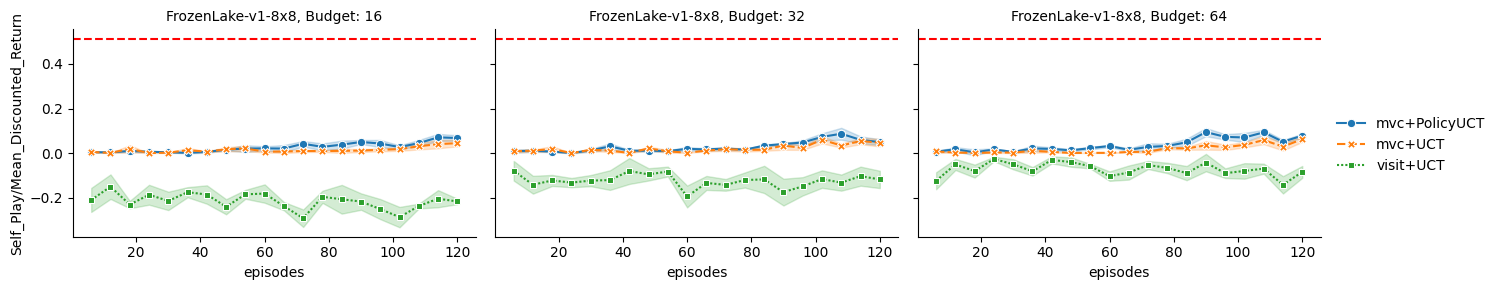

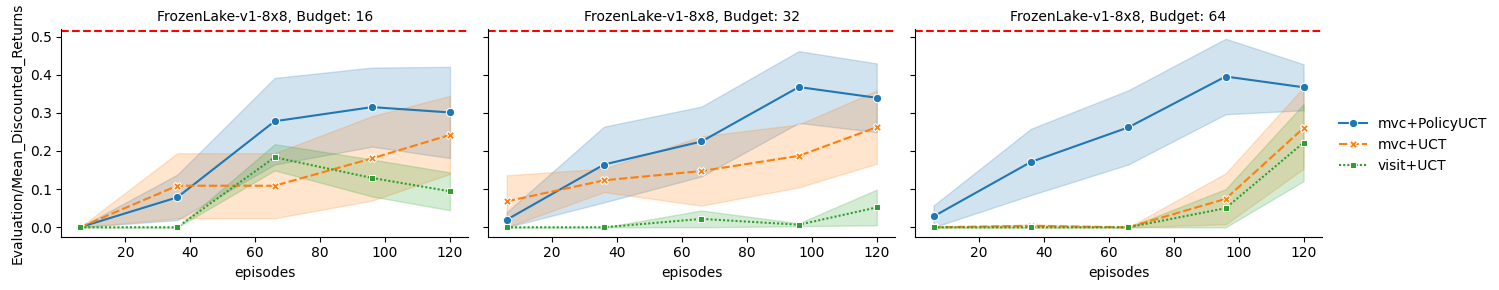

In [10]:

env_description = "FrozenLake-v1-8x8"
runs = df[df["env_description"] == env_description]
optimum_value = runs["optimal_value"][0]

metrics = ["Self_Play/Mean_Discounted_Return", "Evaluation/Mean_Discounted_Returns"]

estimator = "mean"

for metric in metrics:
    # Step 1: Set up the FacetGrid to create one subplot for each unique value in 'env_description'
    # Note: adjust size and aspect to fit your data and preference
    g = sns.FacetGrid(data=df, row="env_description", col="planning_budget", sharex="col", sharey="row", aspect=1.5)

    # Step 2: Use map_dataframe to draw the lineplots on each subplot
    # Pass sns.lineplot as the plotting function and its arguments
    g.map_dataframe(sns.lineplot,
                    x=x_metric, y=metric,
                    hue="policy_combination", style="policy_combination",
                    markers=True, errorbar="se", estimator="mean")  # adjust 'estimator' as needed

    # add a horizontal line for the optimal value to each subplot

    for ax in g.axes.flat:
        ax.axhline(optimum_value, ls="--", color="red")



    # Step 3: Adjusting aesthetics (optional)
    # Adding a legend
    g.add_legend()
    g.set_titles("{row_name}, Budget: {col_name}")


    # Adjust the labels/titles as needed
    g.set_axis_labels(x_metric, metric)
    # increase the width of the plot
    # g.fig.set_figwidth(10)
    # plt.suptitle(metric)
    # plt.tight_layout()
    plt.savefig(f'{save_folder}/{x_metric}_{name_fn(metric).replace(" ", "_")}_{env_description}_{estimator}.pdf')

    plt.show()
